[NumPyroによるベイジアン線形単回帰の実装](https://zenn.dev/kajyuuen/articles/c89a9ca9a2d2f87a209e)

In [1]:
import seaborn
import jax
import numpyro

In [2]:
N = 100

In [3]:
import dataclasses
@dataclasses.dataclass
class PRNGIterator():
    seed: int = 0
    def __iter__(self):
        self.key = jax.random.PRNGKey(self.seed)
        return self
    def __next__(self):
        self.key, subkey = jax.random.split(self.key)
        return self.key
prng_iter = iter(PRNGIterator(0))

<AxesSubplot:>

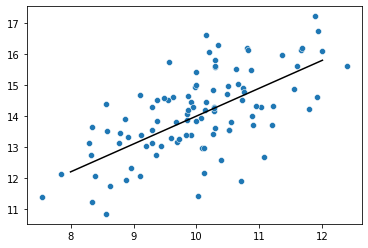

In [4]:
alpha_true, beta_true, eps_true = 0.9, 5, 1
x = jax.random.normal(next(prng_iter), (N,)) + 10
y = alpha_true * x + beta_true + jax.random.normal(next(prng_iter), (N,))*eps_true
seaborn.lineplot(x=jax.numpy.linspace(8, 12, N), y=alpha_true * jax.numpy.linspace(8, 12, N) + beta_true, color='black')
seaborn.scatterplot(x=x, y=y)

In [5]:
def model(x, y=None):
    alpha = numpyro.sample("alpha", numpyro.distributions.Normal(0, 1))
    beta = numpyro.sample("beta", numpyro.distributions.Normal(0, 10))
    eps = numpyro.sample("eps", numpyro.distributions.HalfCauchy(5))

    mu = numpyro.deterministic("mu", alpha * x + beta)

    with numpyro.plate("data", size=len(x)):
        y_pred = numpyro.sample("y_pred", numpyro.distributions.Normal(mu, eps), obs=y)

In [6]:
kernel = numpyro.infer.NUTS(model)
mcmc = numpyro.infer.MCMC(kernel, num_samples=1000, num_warmup=300, num_chains=4, chain_method="parallel")
mcmc.run(next(prng_iter), x, y)

/home/yuta/.local/lib/python3.9/site-packages/numpyro/infer/mcmc.py:257: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  warnings.warn('There are not enough devices to run parallel chains: expected {} but got {}.'
sample: 100%|██████████| 1300/1300 [00:01<00:00, 1048.57it/s, 39 steps of size 9.78e-02. acc. prob=0.91]


In [7]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha      0.84      0.10      0.84      0.67      1.01   1080.08      1.00
      beta      5.65      1.04      5.65      4.04      7.46   1083.18      1.00
       eps      1.05      0.08      1.05      0.93      1.18   1652.80      1.00

Number of divergences: 0


In [8]:
posterior_samples = mcmc.get_samples()
posterior_predictive = numpyro.infer.Predictive(model, posterior_samples=posterior_samples)(next(prng_iter), x)

In [13]:
mcmc

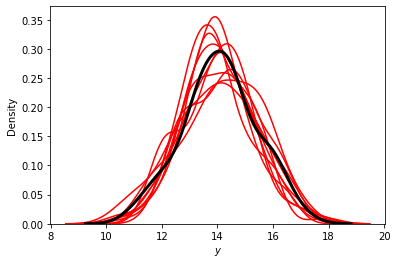

In [9]:
for y_pred in posterior_predictive["y_pred"][0:10]:
    seaborn.kdeplot(y_pred, alpha=0.1, color='red')
ax = seaborn.kdeplot(y, linewidth=3, color='black')
_ = ax.set_xlabel('$y$')

In [10]:
import itertools

print(len(posterior_predictive['y_pred']))
print(len(posterior_predictive['y_pred'][0]))
print(len(list(x)))
listed_post = [list(y_pred) for y_pred in posterior_predictive['y_pred']]
flatten = list(itertools.chain.from_iterable(listed_post))
print(len(flatten))
print(flatten[0])

4000
100
100
400000
14.617019


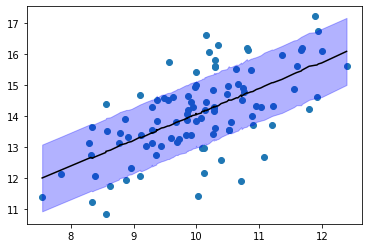

In [14]:
import matplotlib.pyplot as plt
idx = x.argsort()
pred_mean = posterior_predictive['y_pred'].mean(axis=0)[idx]
pred_std = posterior_predictive['y_pred'].std(axis=0)[idx]

plt.plot(x[idx], pred_mean, color='black')
plt.scatter(x[idx], y[idx])
plt.fill_between(x[idx], pred_mean - pred_std, pred_mean + pred_std, alpha=0.3, color='blue')
